# Final model

* Preprocessing of training and problem test data is done 
* Final training and problem test data is created
* In previously defined training sets, every training data had some new features, some of the features found to be important, hence these  features are added in new training and problem test which result in final data 
* This time training data is split in 3 part train set, dev set and test set(this test set is different from the problem test set, this test set is part of training data itself use for the final test of the model)
* Gradient boosting classifier is used, the model is trained on train set and hyperparameter tuning is done with the help of dev set
* After fine-tuning of hyperparameter of the model it is tested over test set before applying on problem test data
* After satisfaction predictions are done over the problem test set 

In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline
import sys
import warnings
warnings.filterwarnings('ignore')
print('python virsion   :',sys.version)
print('pandas virsion   :',pd.__version__)
print('sklearn virsion  :',sklearn.__version__)
print('numpy virsion    :',pd.__version__)

python virsion   : 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
pandas virsion   : 0.23.4
sklearn virsion  : 0.20.1
numpy virsion    : 0.23.4


In [2]:
#Importing train and problem test set
train_data= pd.read_csv('train.csv')
test_data= pd.read_csv('test.csv')

## Pre Processing of both data set, same as done before

In [3]:
 #deleting 'employee_id' and 'region' column
train_data.drop(['employee_id','region'],axis=1,inplace=True)
test_data.drop(['employee_id','region'],axis=1,inplace=True)                 

In [4]:
#filling missing values
train_data.education.fillna('missing',inplace=True)
for i in range(train_data.shape[0]):
    if train_data['education'][i]=='missing':
        if train_data['age'][i]<=25:
            train_data['education'][i]='Below Secondary'
        if train_data['age'][i]>25 and train_data['age'][i]<=32:
            train_data['education'][i]="Bachelor's"
        if train_data['age'][i]>32:
            train_data['education'][i]="Master's & above"
            

test_data.education.fillna('missing',inplace=True)
for i in range(test_data.shape[0]):
    if test_data['education'][i]=='missing':
        if test_data['age'][i]<=25:
            test_data['education'][i]='Below Secondary'
        if test_data['age'][i]>25 and test_data['age'][i]<=32:
            test_data['education'][i]="Bachelor's"
        if test_data['age'][i]>32:
            test_data['education'][i]="Master's & above"

train_data.previous_year_rating.fillna(train_data.previous_year_rating.mode()[0],inplace=True)
test_data.previous_year_rating.fillna(train_data.previous_year_rating.mode()[0],inplace=True)

In [5]:
#creating final train and test set, adding some importan features
final_train= train_data.copy()
final_test= test_data.copy()

final_train['service_ratio']= final_train['length_of_service']/final_train['age']
final_test['service_ratio']= final_test['length_of_service']/final_test['age']

final_train['addtion_feature']= train_data['previous_year_rating']+train_data['KPIs_met >80%']+train_data['avg_training_score']+train_data['awards_won?']
final_test['addtion_feature']= test_data['previous_year_rating']+test_data['KPIs_met >80%']+test_data['avg_training_score']+test_data['awards_won?']

final_train['total_training_score'] = train_data['no_of_trainings']*train_data['avg_training_score']
final_test['total_training_score'] = test_data['no_of_trainings']*test_data['avg_training_score']

final_train['education'] = train_data['education'].map({'Below Secondary':0,"Bachelor's":1,"Master's & above":2}).astype(np.int)
final_test['education'] = test_data['education'].map({'Below Secondary':0,"Bachelor's":1,"Master's & above":2}).astype(np.int)

In [6]:
#scaling both data
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
def scaleColumns(train,test, cols_to_scale):
    for col in cols_to_scale:
        train[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(train[col])),columns=[col])
        test[col] = pd.DataFrame(scaler.transform(pd.DataFrame(test[col])),columns=[col])
    return train, test


fina_train,final_test = scaleColumns(final_train,final_test, ['no_of_trainings',
                                                              'age','previous_year_rating',
                                                              'length_of_service',
                                                              'avg_training_score',
                                                              'service_ratio',
                                                              'addtion_feature',
                                                              'total_training_score',
                                                              'total_training_score',
                                                              'education'])

In [7]:
#creating dummy variable
final_train = pd.get_dummies(final_train, drop_first=True)
final_test = pd.get_dummies(final_test, drop_first=True)

In [8]:
#adding one more feature which is 1 dimensional represention of data with the help of PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
d1_train = pca.fit_transform(final_train.drop(['is_promoted'],axis=1))
d1_test = pca.transform(final_test)

final_train['summay']= d1_train
final_test['summay']= d1_test

train_data, test =train_test_split(final_train, test_size=0.3, random_state=42)
train, dev =train_test_split(train_data, test_size=0.3, random_state=42)

## Model building

In [9]:
#separating independent variable i.e. X and dependent variable i.e. y
X_train = train.drop(['is_promoted'],axis=1)
y_train = train['is_promoted']

X_dev = dev.drop(['is_promoted'],axis=1)
y_dev = dev['is_promoted']

X_test = test.drop(['is_promoted'],axis=1)
y_test = test['is_promoted']

In [10]:
#defining the model
model=GradientBoostingClassifier(max_depth=3,min_samples_split=5,
                                  min_samples_leaf=7,
                                  min_weight_fraction_leaf=.01,n_estimators=1000, random_state=42,max_features=20)

In [11]:
#fitting model
model.fit(X_train,y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=20, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=7, min_samples_split=5,
              min_weight_fraction_leaf=0.01, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [12]:
#precting probability of dev set
y_prob_dev = model.predict_proba(X_dev)

In [13]:
#applying 'for loop' for getting max f1 score and respective threshold 
f1score = []
max_f1 =0
x =[]
for i in range(100):
    y_hat_prob_dev = y_prob_dev[:,1]> i/100
    f1 = f1_score(y_dev, y_hat_prob_dev)
    f1score.append(f1)
    x.append(i)
    if f1 > max_f1:
        max_f1 = f1
        threshold= i/100
print('maximum f1 score :',max_f1)
print('threshold         :',threshold)
    
   

maximum f1 score : 0.5376623376623376
threshold         : 0.36


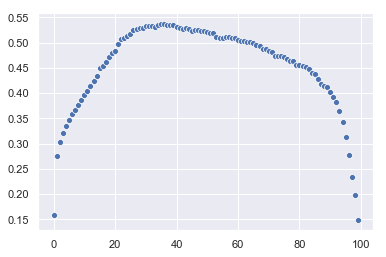

In [14]:
# f1 score vs threshold probability curve
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
sns.scatterplot(x,f1score)

#### After fine tuning of model testing of test set 

In [15]:
y_prob_test = model.predict_proba(X_test)
y_hat_prob_test = y_prob_test[:,1]> threshold
f1_score(y_test, y_hat_prob_test)

0.5091267883571781

#### After satisfactory performance, model predicaton made on problem test 

In [16]:
test_X= final_test
test_y_prob= model.predict_proba(test_X)
test_y_hat_prob = test_y_prob[:,1]>threshold

In [17]:
#saving predicton of problem test file for submission
test_y=pd.DataFrame(data=test_y_hat_prob,columns=["is_promoted"]).astype('int64')
prediction = pd.concat([pd.read_csv('test.csv').employee_id,test_y],axis=1)
prediction.to_csv('submission.csv',index=False)

# End